In [ ]:
# %matplotlib inline

# Load packages

In [72]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

import moabb
# DEBUG, INFO, WARNING, ERROR, CRITICAL
moabb.set_log_level(level="WARNING")
from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery, FilterBankLeftRightImagery, MotorImagery, FilterBankMotorImagery
from moabb.pipelines.utils import FilterBank
from moabb.evaluations import WithinSessionEvaluation, CrossSessionEvaluation, CrossSubjectEvaluation
from moabb.utils import setup_seed
from moabb.analysis.plotting import score_plot
# from moabb.pipelines.features import LogVariance

import mne
mne.set_log_level(False)
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# from pyriemann.estimation import Covariances
# from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import MDM

seed = 0
setup_seed(seed)

import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
import einops.layers.torch

from braindecode.models import EEGNetv4
from braindecode import EEGClassifier
from braindecode.models.base import EEGModuleMixin
from braindecode.models.modules import Ensure4d

from skorch.callbacks import EarlyStopping, EpochScoring
from skorch.dataset import ValidSplit

# Print Information PyTorch
print(f"Torch Version: {torch.__version__}")

# Set up GPU if it is there
cuda = torch.cuda.is_available()
device = "cuda:2" if cuda else "cpu"
print("GPU is", "AVAILABLE" if cuda else "NOT AVAILABLE")

We try to set the tensorflow seeds, but it seems that tensorflow is not installed. Please refer to `https://www.tensorflow.org/` to install if you need to use this deep learning module.
Torch Version: 2.3.0+cu121
GPU is AVAILABLE


# Dataset

https://neurotechx.github.io/moabb/api.html#module-moabb.datasets

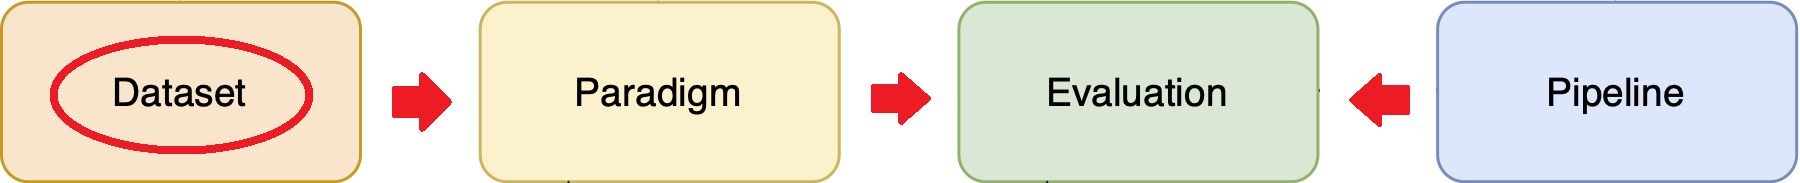

In [74]:
from moabb.datasets import BNCI2014_001, BNCI2014_004, Cho2017, GrosseWentrup2009, Lee2019_MI, PhysionetMI, Schirrmeister2017, Shin2017A, Stieger2021, Weibo2014, Zhou2016

In [75]:
dataset_classes = [
    BNCI2014_001, 
]

datasets = [dataset() for dataset in dataset_classes]

# Paradigm

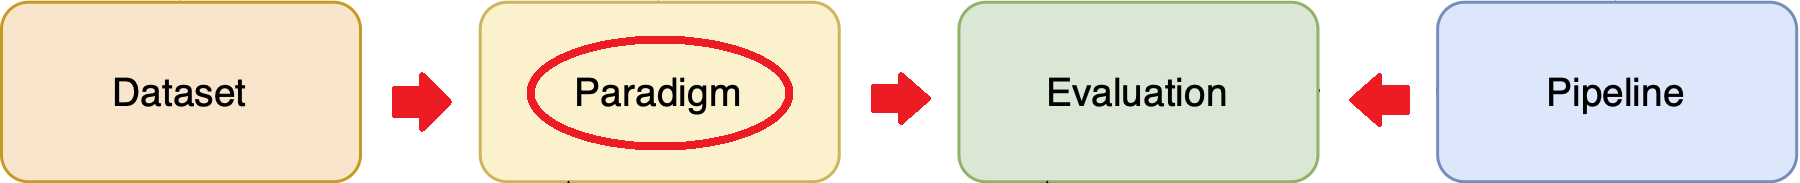

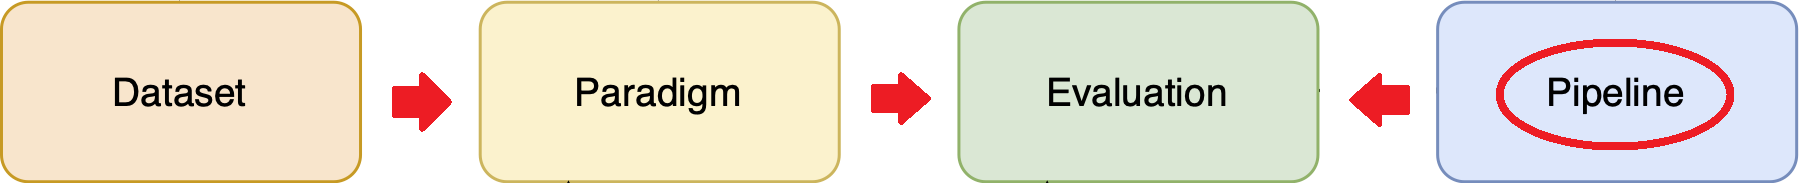

# WithinSessionEvaluation 

In [80]:
fmin = 8
fmax = 32

n_filters = 1
n_components = 8
paradigm = LeftRightImagery(fmin=fmin, fmax=fmax)

n_components_fb = 2
filters_v1 = [[8, 12], [12, 16], [16, 24], [24, 32]]
n_filters = len(filters_v1)
paradigm_fb_v1 = FilterBankLeftRightImagery(filters=filters_v1)

## FBCSP + LR

In [110]:
fb = make_pipeline(FilterBank(make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"))))
x = np.random.normal(size=(100, 22, 1000, 3))
fb.fit(x)

Pipeline(steps=[('filterbank',
                 FilterBank(estimator=Pipeline(steps=[('covariances', Covariances(estimator='oas')), ('tangentspace', TangentSpace())])))])

In [111]:
y = fb.transform(x)

In [112]:
y.shape

(100, 759)

In [113]:
pipelines_baseline_fb_v1, pipelines_baseline_fb_v2 = {}, {}

n_components_fb = 2
filters_v1 = [[8, 12], [12, 16], [16, 24], [24, 32]]
n_filters = len(filters_v1)
paradigm_fb_v1 = FilterBankLeftRightImagery(filters=filters_v1)
pipelines_baseline_fb_v1["FBCSP+LR 4/2"] = make_pipeline(FilterBank(CSP(n_components=n_components_fb)), LogisticRegression(penalty=None, multi_class='multinomial'))
pipelines_baseline_fb_v1["FB+TS+LR 4"] = make_pipeline(FilterBank(make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"))), LDA())
evaluation = WithinSessionEvaluation(paradigm=paradigm_fb_v1, datasets=datasets, suffix="baseline", overwrite=True, hdf5_path='hdf5_path', random_state=seed)
results_within_session_baseline_fb_v1 = evaluation.process(pipelines_baseline_fb_v1)


filters_v2 = [[i, i+4] for i in range(4, 32, 4)]
paradigm_fb_v2 = FilterBankLeftRightImagery(filters=filters_v2)
pipelines_baseline_fb_v2["FBCSP+LR 7/10"] = make_pipeline(FilterBank(CSP(n_components=10)), LogisticRegression(penalty=None, multi_class='multinomial'))
pipelines_baseline_fb_v2["FB+TS+LR 7"] = make_pipeline(FilterBank(make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"))), LDA())
evaluation = WithinSessionEvaluation(paradigm=paradigm_fb_v2, datasets=datasets, suffix="baseline", overwrite=True, hdf5_path='hdf5_path', random_state=seed)
results_within_session_baseline_fb_v2 = evaluation.process(pipelines_baseline_fb_v2)

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [09:52<00:00, 65.86s/it]


2024-06-05 13:10:30,088 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


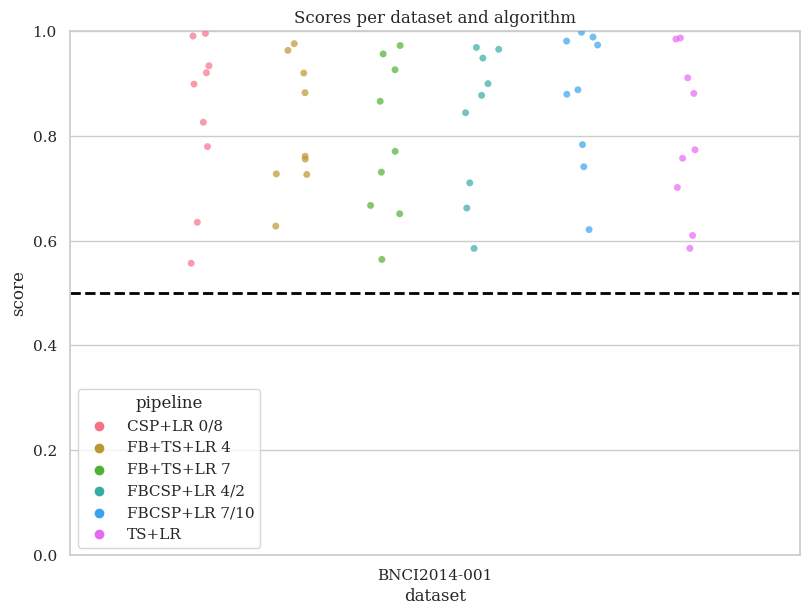

In [114]:
results_within_session_baseline = pd.concat([
    results_within_session_baseline_bb, 
    results_within_session_baseline_fb_v1,
    results_within_session_baseline_fb_v2,
])
results_within_session_baseline = results_within_session_baseline.reset_index(drop=True)
results_within_session_baseline.to_csv('results/results_within_session_baseline.csv')

f, q = score_plot(results_within_session_baseline)
f.set_size_inches(8, 6)

## Deep Learning

In [11]:
import sys
sys.path.insert(0, 'libs/envelope_detector')
import importlib
import envelope_detector
importlib.reload(envelope_detector)

<module 'envelope_detector' from '/home/amvosk/BCI/libs/envelope_detector/envelope_detector/__init__.py'>

In [12]:
from skorch.callbacks import Checkpoint

In [16]:
class CustomCheckpoint(Checkpoint):
    def on_train_end(self, net, **kwargs):
        super().on_train_end(net, **kwargs)
        # Add any action here, for example:
        # print("Training has ended. Custom actions could be placed here.")
        net.load_params(f_params='model_checkpoints/params.pt')

In [17]:
def create_clf(model, optimizer__lr, batch_size, max_epochs, patience, seed=0):
    return EEGClassifier(
        module=model,
        optimizer=torch.optim.Adam,
        optimizer__lr=optimizer__lr,
        batch_size=batch_size,
        max_epochs=max_epochs,
        train_split=ValidSplit(0.2, random_state=seed),
        device=device,
        callbacks=[
            EarlyStopping(monitor="valid_loss", patience=patience),
            EpochScoring(scoring="accuracy", on_train=True, name="train_acc", lower_is_better=False),
            EpochScoring(scoring="accuracy", on_train=False, name="valid_acc", lower_is_better=False),
            # CustomCheckpoint(monitor='valid_loss_best', dirname='model_checkpoints'),
        ],
        verbose=0,
    )

In [18]:
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm=1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x):
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)

In [19]:
class SpatialNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        n_components=8,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, n_components

        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")
        self.conv_spatial = Conv2dWithConstraint(
            1,
            self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=1,
            padding=(0, 0),
        )

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_spatial(x)
        x = torch.pow(x, 2)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [20]:
class SpatioTemporalNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=2,
        n_components=4,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")


        self.conv_temporal = nn.Conv2d(
            1,
            self.n_filters,
            (1, self.kernel_length),
            stride=1,
            bias=False,
            padding=(0, self.kernel_length // 2),
        )

        self.conv_spatial = Conv2dWithConstraint(
            self.n_filters,
            self.n_filters * self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.n_filters,
            padding=(0, 0),
        )

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_filters * self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = torch.pow(x, 2)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [21]:
class SpatialSincNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=2,
        n_components=4,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
        r_spatial = False,
        r_temporal = False, 
        seed=42,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")

        self.conv_temporal = envelope_detector.SincLayer2d(
            in_channels=1,
            out_channels=self.n_filters,
            kernel_size=self.kernel_length, srate=250, fmin_init=fmin, fmax_init=fmax,
            seed=seed,
        )
        
        self.conv_spatial = Conv2dWithConstraint(
            self.n_filters,
            self.n_filters * self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.n_filters,
            padding=(0, 0),
        )

        if r_spatial:
            self.conv_spatial.weight.requires_grad = False
        if r_temporal:
            self.conv_temporal.coef_freq.requires_grad = False
            self.conv_temporal.coef_bandwidth.requires_grad = False

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_filters * self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = torch.pow(x, 2)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [22]:
class SpatialSincNetv2(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=2,
        n_components=4,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
        r_spatial = False,
        r_temporal = False, 
        seed=42,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch ch t")

        self.conv_spatial_1 = nn.Conv1d(
            self.n_chans, 
            self.n_components, 
            kernel_size=1
        )
        
        self.conv_temporal = envelope_detector.SincLayer1d(
            in_channels=self.n_components,
            out_channels=self.n_filters,
            kernel_size=self.kernel_length, srate=250, fmin_init=fmin, fmax_init=fmax,
            seed=seed,
        )

        self.conv_spatial_2 = nn.Conv1d(
            self.n_filters, 
            self.n_components, 
            kernel_size=1,
            groups=self.n_components, 
        )

        if r_spatial:
            self.conv_spatial.weight.requires_grad = False
        if r_temporal:
            self.conv_temporal.coef_freq.requires_grad = False
            self.conv_temporal.coef_bandwidth.requires_grad = False

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat t -> batch (feat t)")
        self.classifier = nn.Linear(self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_spatial_1(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial_2(x)
        x = torch.pow(x, 2)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [23]:
class SpatialWaveletNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=2,
        n_components=4,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
        r_spatial = False,
        r_temporal = False, 
        seed=42,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")

        self.conv_temporal = envelope_detector.WaveletLayer2d(
            in_channels=1,
            out_channels=self.n_filters,
            kernel_size=self.kernel_length, srate=250, fmin_init=fmin, fmax_init=fmax,
            seed=seed,
        )
        
        self.conv_spatial = Conv2dWithConstraint(
            self.n_filters,
            self.n_filters * self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.n_filters,
            padding=(0, 0),
        )

        if r_spatial:
            self.conv_spatial.weight.requires_grad = False
        if r_temporal:
            self.conv_temporal.coef_freq.requires_grad = False
            self.conv_temporal.coef_bandwidth.requires_grad = False

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_filters * self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = torch.pow(x, 2)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [24]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# LEARNING_RATE = 0.0625 * 0.01  # parameter taken from Braindecode
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0  # parameter taken from Braindecode
BATCH_SIZE = 64  # parameter taken from BrainDecode
EPOCH = 300
PATIENCE = 100

In [25]:
# # Create the pipelines
pipelines_dl = {}

pipelines_dl["SpatialNet 0/8"] = make_pipeline(create_clf(
    model=SpatialNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        n_components=n_components,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialTemporalNet 4/2"] = make_pipeline(create_clf(
    model=SpatioTemporalNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=n_filters,
        n_components=n_components_fb,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialTemporalNet 20/20"] = make_pipeline(create_clf(
    model=SpatioTemporalNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=20,
        n_components=20,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialSincNet 4/2"] = make_pipeline(create_clf(
    model=SpatialSincNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=n_filters,
        n_components=n_components_fb,
        r_temporal = False,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialSincNet 20/20"] = make_pipeline(create_clf(
    model=SpatialSincNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=20,
        n_components=20,
        r_temporal = False,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialSincNet 4/2 (Random Temporal)"] = make_pipeline(create_clf(
    model=SpatialSincNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=n_filters,
        n_components=n_components_fb,
        r_temporal = True,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialWaveletNet 4/2"] = make_pipeline(create_clf(
    model=SpatialWaveletNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=n_filters,
        n_components=n_components_fb,
        r_temporal = False,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialWaveletNet 20/20"] = make_pipeline(create_clf(
    model=SpatialWaveletNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=20,
        n_components=20,
        r_temporal = False,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl["SpatialWaveletNet 4/2 (Random Temporal)"] = make_pipeline(create_clf(
    model=SpatialWaveletNet(
        n_chans=22,
        n_outputs=2,
        n_times=1001,
        kernel_length=251,
        n_filters=n_filters,
        n_components=n_components_fb,
        r_temporal = True,
        seed=seed,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

In [26]:
evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, suffix="dl", overwrite=True, hdf5_path='hdf5_path', random_state=seed)
results_within_session_dl = evaluation.process(pipelines_dl)

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [3:51:29<00:00, 1543.30s/it]  


In [27]:
results_within_session_dl.to_csv('results/results_within_session_dl.csv')

In [55]:
results_within_session_baseline = pd.read_csv('results/results_within_session_baseline.csv', index_col='Unnamed: 0')

2024-06-05 13:32:18,997 WARNING MainThread moabb.analysis.plotting Dataset names are too similar, turning off name shortening


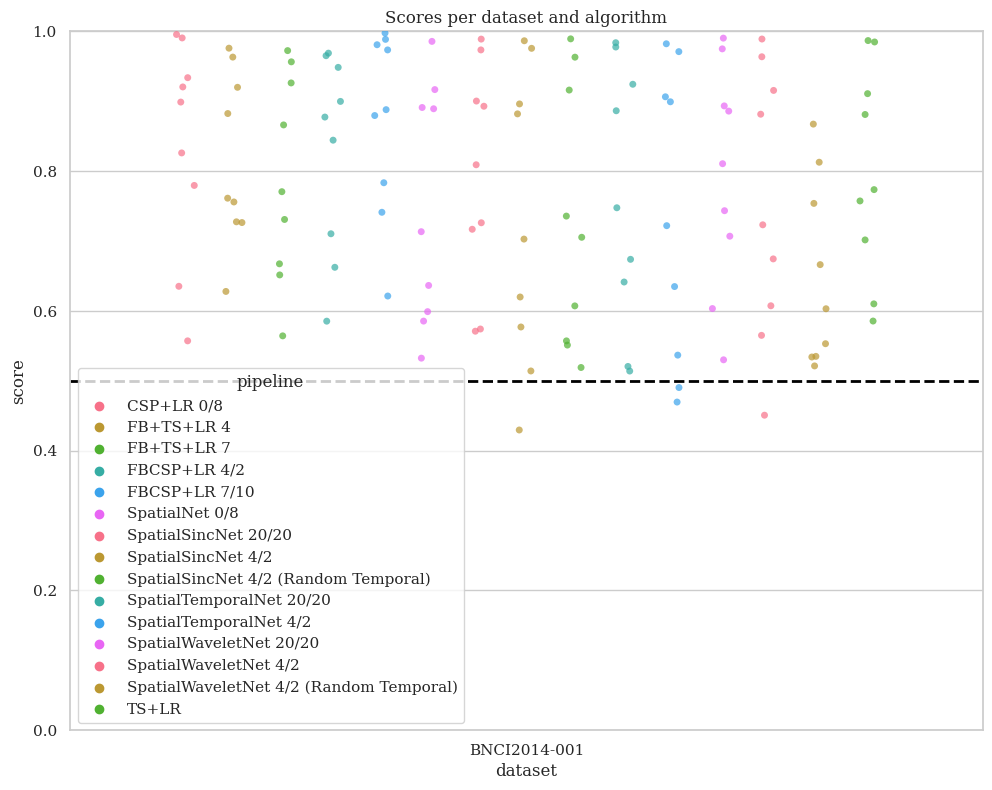

In [115]:
results_within_session = pd.concat([results_within_session_baseline, results_within_session_dl])
results_within_session = results_within_session.reset_index(drop=True)

f, q = score_plot(results_within_session)
f.set_size_inches(10, 8)

In [116]:
f.savefig('results/test_temporal_filters')

In [59]:
results_within_session

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.915578,0.308855,144.0,1,0train,22,2,BNCI2014-001,CSP+LR 0/8
1,0.951020,0.312525,144.0,1,1test,22,2,BNCI2014-001,CSP+LR 0/8
2,0.642041,0.297311,144.0,2,0train,22,2,BNCI2014-001,CSP+LR 0/8
3,0.627823,0.306285,144.0,2,1test,22,2,BNCI2014-001,CSP+LR 0/8
4,0.988299,0.316506,144.0,3,0train,22,2,BNCI2014-001,CSP+LR 0/8
...,...,...,...,...,...,...,...,...,...
211,0.536531,2.965573,144.0,7,1test,22,2,BNCI2014-001,SpatialNet 0/8
212,0.988367,5.707278,144.0,8,0train,22,2,BNCI2014-001,SpatialNet 0/8
213,0.982041,5.610588,144.0,8,1test,22,2,BNCI2014-001,SpatialNet 0/8
214,0.809388,5.069430,144.0,9,0train,22,2,BNCI2014-001,SpatialNet 0/8


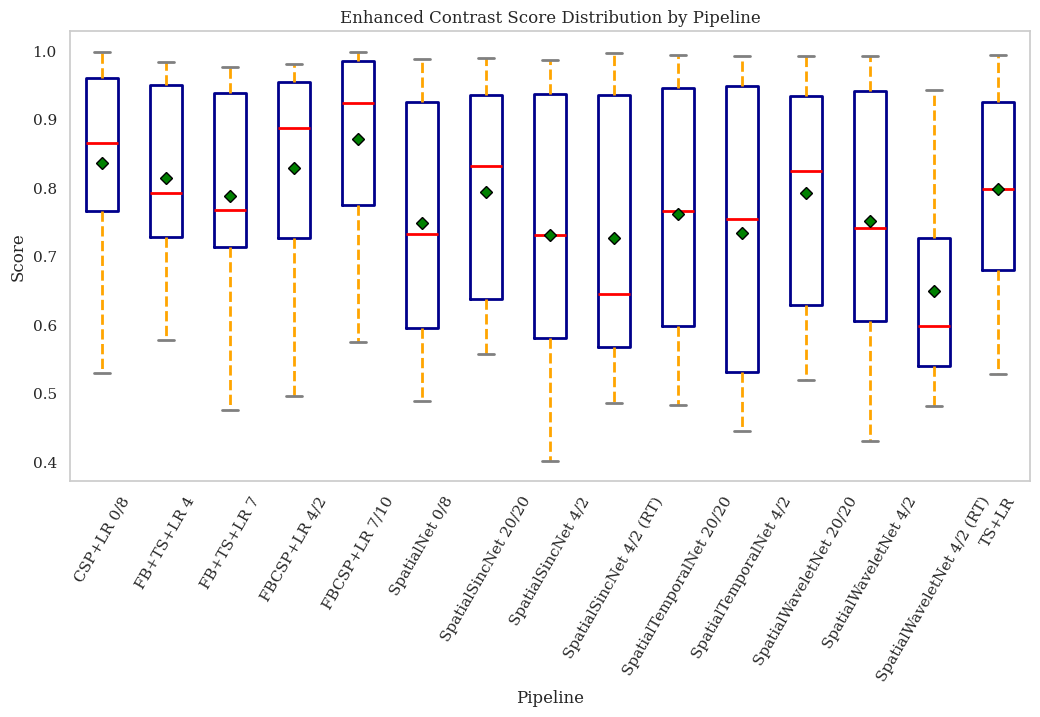

In [118]:
import matplotlib.pyplot as plt

# Assuming 'results_within_session' is your DataFrame

# Create a subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot with customized styles
boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
whiskerprops = dict(linestyle='--', linewidth=2, color='orange')
capprops = dict(linestyle='-', linewidth=2, color='grey')
medianprops = dict(linestyle='-', linewidth=2, color='red')
meanprops = dict(marker='D', markeredgecolor='black', markerfacecolor='green')

results_within_session.boxplot(
    column='score', by='pipeline', ax=ax,
    grid=False, showmeans=True,
    boxprops=boxprops,
    whiskerprops=whiskerprops,
    capprops=capprops,
    medianprops=medianprops,
    meanprops=meanprops
)

# Set plot titles and labels
labels = [text.get_text().replace("Random Temporal", "RT") if "Random Temporal" in text.get_text() else text.get_text() for text in ax.get_xticklabels()]
ax.set_xticklabels(labels)

ax.set_title('Enhanced Contrast Score Distribution by Pipeline')
ax.set_xlabel('Pipeline')
ax.set_ylabel('Score')
plt.suptitle('')  # Remove the default suptitle to clean up the title
plt.xticks(rotation=60)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

fig.savefig('results/test_temporal_filters_boxplot')

In [36]:
evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, suffix="dl", overwrite=True, hdf5_path='hdf5_path', random_state=seed)
results_within_session_dl_v3 = evaluation.process(pipelines_dl_v2)

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [34:49<00:00, 232.18s/it]


In [37]:
results_within_session_dl_v3.to_csv('results/results_within_session_dl_v3.csv')

In [50]:
filters = [[i, i+4] for i in range(4, 32, 4)]
paradigm_fb_v3 = FilterBankLeftRightImagery(filters=filters)

pipelines_baseline_fb_v3 = {}
pipelines_baseline_fb_v3["FB7CSP10+LR"] = make_pipeline(FilterBank(CSP(n_components=10)), LogisticRegression(penalty=None, multi_class='multinomial'))

evaluation = WithinSessionEvaluation(paradigm=paradigm_fb_v3, datasets=datasets, suffix="baseline", overwrite=True, hdf5_path='hdf5_path', random_state=seed)
results_within_session_baseline_fb_v3 = evaluation.process(pipelines_baseline_fb_v3)

BNCI2014-001-WithinSession: 100%|██████████| 9/9 [06:38<00:00, 44.32s/it]


In [78]:
class SpatialSincBBlNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=1,
        n_components=8,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")

        self.conv_temporal = envelope_detector.SincLayer2d(
            n_channels=1,
            kernel_size=self.kernel_length, srate=250, fmin_init=8, fmax_init=35, 
            freq=torch.tensor([22.0]), bandwidth=torch.tensor([2 * 18 / 22])
        )

        self.conv_spatial = Conv2dWithConstraint(
            self.n_filters,
            self.n_filters * self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.n_filters,
            padding=(0, 0),
        )

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_filters * self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = torch.pow(2, x)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [79]:
class SpatialWaveletBBlNet(EEGModuleMixin, nn.Module):
    def __init__(
        self,
        n_chans=None,
        n_outputs=None,
        n_times=None,
        kernel_length=125,
        n_filters=1,
        n_components=8,
        chs_info=None,
        input_window_seconds=None,
        sfreq=None,
    ):
        super().__init__(
            n_outputs=n_outputs,
            n_chans=n_chans,
            chs_info=chs_info,
            n_times=n_times,
            input_window_seconds=input_window_seconds,
            sfreq=sfreq,
        )
        self.kernel_length = kernel_length
        self.n_filters = n_filters
        self.n_components = n_components
        del n_outputs, n_chans, chs_info, n_times, input_window_seconds, sfreq, kernel_length, n_filters, n_components
        
        self.ensuredims = Ensure4d()
        self.rearrange_picture = einops.layers.torch.Rearrange("batch ch t 1 -> batch 1 ch t")

        self.conv_temporal = envelope_detector.WaveletLayer2d(
            n_channels=1,
            kernel_size=self.kernel_length, srate=250, fmin_init=8, fmax_init=35, 
            freq=torch.tensor([22.0]), bandwidth=torch.tensor([2 * 18 / 22])
        )

        self.conv_spatial = Conv2dWithConstraint(
            self.n_filters,
            self.n_filters * self.n_components,
            (self.n_chans, 1),
            max_norm=1,
            stride=1,
            bias=False,
            groups=self.n_filters,
            padding=(0, 0),
        )

        self.rearrange_features = einops.layers.torch.Rearrange("batch feat ch t -> batch (feat ch t)")
        self.classifier = nn.Linear(self.n_filters * self.n_components, self.n_outputs)
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.ensuredims(x)
        x = self.rearrange_picture(x)
        x = self.conv_temporal(x)
        x = self.conv_spatial(x)
        x = torch.pow(2, x)
        x = torch.mean(x, dim=-1, keepdims=True)
        x = torch.log(x + torch.finfo().eps)
        x = self.rearrange_features(x)
        x = self.classifier(x)
        x = self.logsoftmax(x)
        return x

In [80]:
pipelines_dl3 = {}

pipelines_dl3["SpatialSincBBlNet"] = make_pipeline(create_clf(
    model=SpatialSincBBlNet(
        n_chans=22,
        n_outputs=3,
        n_times=1001,
        kernel_length=251,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

pipelines_dl3["SpatialWaveletBBlNet"] = make_pipeline(create_clf(
    model=SpatialWaveletBBlNet(
        n_chans=22,
        n_outputs=3,
        n_times=1001,
        kernel_length=251,
    ), 
    optimizer__lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE, 
    max_epochs=EPOCH, 
    patience=PATIENCE, 
    seed=seed
))

In [81]:
evaluation = CrossSubjectEvaluation(
    paradigm=paradigm,
    datasets=dataset,
    suffix="example",
    overwrite=True,
    return_epochs=False,
    n_jobs=1,
)

In [82]:
# results_cross_subject_dl3 = evaluation.process(pipelines_dl3)

In [83]:
# results_cross_subject_dl3.to_csv('results/results_cross_subject_dl3.csv')

In [84]:
# results_cross_subject = pd.concat([
#     results_bb_baseline, 
#     results_fb_baseline, 
#     results_cross_subject_dl1, 
#     results_cross_subject_dl2,
#     results_cross_subject_dl3,
# ])
# results_cross_subject = results_cross_subject.reset_index(drop=True)